# Detecting Cancer in Gigapixel Medical Images
## Applied Deep Learning (Spring 2018) 
### Akarsh Zingade, Kiran Ramesh, Arjun D'Cunha

### YouTube [demo](). GitHub [repo](https://github.com/kira-95/adl_cancer_detection).

Note: The 22 slides and tumor masks prepared by Prof. Joshua Gordon can be found [here](https://drive.google.com/drive/folders/1rwWL8zU9v0M27BtQKI52bF6bVLW82RL5?usp=sharing). The super set of this dataset can be found at [CAMELYON16](https://camelyon17.grand-challenge.org/Data/)


### Summary

We base our approach on the the work by Google AI's [Lui et al. (2017)](https://arxiv.org/abs/1703.02442) in "Detecting Cancer Metastases on Gigapixel Pathology Images". We use ImageNet pretrained architecture and then use transfer learning to solve the problem of detecting cancer cells in the images. We train it using a sliding-window based approach, where we train the model using the patches extracted using the sliding windows. Once the model is trained, we create a heatmap of the prediction on medical slides that were not used during training.


### Flow of the Notebook.

1. Load the dataset created by the Extract Notebook
2. Choose the following that is desired:
    a) Zoom Level of the slide.
    b) Sliding window size
    c) Architecture for training.
3. Performs two levels of transfer learning.
    a) Adds Dense layers to the pretrained, freeze the pretrained layers, train the newly added layers.
    b) Unfreeze all or few higher layers of the pretrained model, train the trainable layers.
4. Evalutate accuracy on extracted test images.
5. Load the test slides, run the heatmap prediction/generation.
6. Report F1, Recall, Precision, AUC score, Sensitivity, Specificity.

#### Train Slides: 031, 064, 075, 084, 091, 094, 096, 101
#### Test Slides:  016, 078, 110


### Import the relevant modules. 
#### Import the Garbage Collection module to free objects

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray
import random
from sklearn import metrics
import sklearn
from sklearn.metrics import confusion_matrix
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, recall_score, precision_score

from matplotlib.colors import Normalize
import gc
gc.collect()

0

#### Check the available GPUs

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15298828348268066637
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13558245996395342332
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2396575151468102313
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15858538906
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14118952347093124142
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [24]:
# Define the levels to be used for training the model.
lev1 = 4
lev2 = 5

# Define the window size for the sliding window.
window_size = (299, 299)

# Define the center size to label the patch as tumorous or as healthy.
center_size = (128, 128)

# Define the stride length for the sliding window
stride = 80

# path to save the model
model_filename = 'multilevel_inception_level_4_5_final.h5' 

# Model to select for training. Options: InceptionV3
select_model = 'inception'

In [4]:
# Load the dataset

data_filename = 'multilevel_levels_' + str(lev1) + '_' + str(lev2) + '.npy'

dataset = np.load(data_filename, allow_pickle=True)

X1_train = np.asarray(dataset.item()['X1_train'])
X2_train = np.asarray(dataset.item()['X2_train'])
y_train = np.asarray(dataset.item()['y_train'])

X1_val = np.asarray(dataset.item()['X1_val'])
X2_val = np.asarray(dataset.item()['X2_val'])
y_val = np.asarray(dataset.item()['y_val'])

X1_test = np.asarray(dataset.item()['X1_test'])
X2_test = np.asarray(dataset.item()['X2_test'])
y_test = np.asarray(dataset.item()['y_test'])

del dataset
gc.collect()

print(X1_train.shape, X1_val.shape, X1_test.shape)
print(X2_train.shape, X2_val.shape, X2_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(1440, 299, 299, 3) (360, 299, 299, 3) (600, 299, 299, 3)
(1440, 299, 299, 3) (360, 299, 299, 3) (600, 299, 299, 3)
(1440,) (360,) (600,)


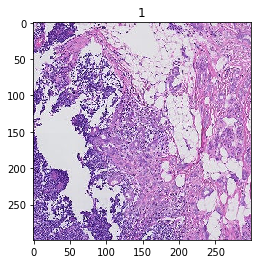

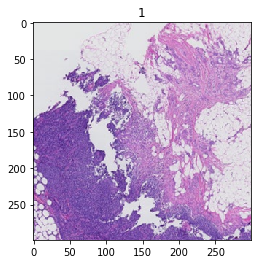

In [5]:
# Show one of the train patches for each of the levels

plt.imshow(X1_train[100])
plt.title(y_train[100])
plt.show()

plt.imshow(X2_train[100])
plt.title(y_train[100])
plt.show()

In [6]:
from keras.preprocessing.image import array_to_img, ImageDataGenerator
from keras.layers import Dense, concatenate, Flatten, Dropout, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, load_model, Sequential
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [7]:
# Define the preprocessing function required for the model

def inception_preprocess_input(x):
    x = x.astype(float)
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

# Define the combined model
# inception for level 1
conv1 = InceptionV3(weights='imagenet', include_top=False, input_shape=(window_size[0], window_size[1], 3))
print('Conv1 Loaded')
in1 = conv1.input
out1 = conv1.output

for layer in conv1.layers:
    layer.trainable = True#False

# inception for level 2
conv2 = InceptionV3(weights='imagenet', include_top=False, input_shape=(window_size[0], window_size[1], 3))
print('Conv2 Loaded')

#rename layers to avoid name collisions
for layer in conv2.layers:
    layer.name = layer.name + str("_2")

in2 = conv2.input
out2 = conv2.output

for layer in conv2.layers:
    layer.trainable = True#False

# merge conv outputs
merged = concatenate([out1, out2])

# fully connected top layers
flat = Flatten()(merged)
drop1 = Dropout(.3)(flat)
dense1 = Dense(128, activation='relu')(drop1)
final_out = Dense(1, activation='sigmoid')(dense1)

# call model
model = Model([in1, in2], final_out)
#preprocess_input = inception_preprocess_input
    
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Conv1 Loaded
Conv2 Loaded
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
input_2_2 (InputLayer)          (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
______________________________________________________________________________________________

In [8]:
# Dataset generator definitions
BATCH_SIZE = 16

def multiple_datagen(X1, X2, y, preprocess_input):
  """ Data generator for two inputs
  inputs:
  - X1: array, input 1 data
  - X2: array, input 2 data
  - y: array, labels
  - preprocess_input: function to pre-process data
  outputs:
  - a batch of data (generator)
  """
  
  # preprocess data
  X1 = preprocess_input(X1)
  X2 = preprocess_input(X2)
  
  while True:
      # shuffle indices    
      idx = np.random.permutation(X1.shape[0])
      # create image generator
      datagen = ImageDataGenerator()

      # get batches with the defied indices
      batches = datagen.flow(X1[idx], y[idx], batch_size=BATCH_SIZE)
      idx0 = 0
      for batch in batches:
          idx1 = idx0 + batch[0].shape[0]

          # yield batch with input2 with the same indexes as input 1 and target
          yield [batch[0], X2[idx[idx0:idx1]]], batch[1]

          idx0 = idx1
          if idx1 >= X1.shape[0]:
              break

preprocess_input = inception_preprocess_input
      
# make datagens for train, val, test
train_generator = multiple_datagen(X1_train, X2_train, y_train, preprocess_input)
val_generator = multiple_datagen(X1_val, X2_val, y_val, preprocess_input)
test_generator = multiple_datagen(X1_test, X2_test, y_test, preprocess_input)

In [9]:
# Training

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_acc',
                                                  min_delta=0.001,
                                                  patience=3,
                                                  verbose=1)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=int(len(X1_train)/BATCH_SIZE)+1,
    epochs=5,
    validation_data=val_generator,
    validation_steps=int(len(X1_val)/BATCH_SIZE)+1,
    callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
91/91 [==============================] - 75s 821ms/step - loss: 0.9396 - acc: 0.6772 - val_loss: 0.3931 - val_acc: 0.8583
Epoch 2/5
91/91 [==============================] - 35s 389ms/step - loss: 0.2312 - acc: 0.9114 - val_loss: 0.1013 - val_acc: 0.9694
Epoch 3/5
91/91 [==============================] - 35s 386ms/step - loss: 0.0852 - acc: 0.9766 - val_loss: 0.0780 - val_acc: 0.9694
Epoch 4/5
87/91 [===========================>..] - ETA: 1s - loss: 0.0833 - acc: 0.9698

MemoryError: 

In [11]:
# Testing
test_loss, test_acc = model.evaluate_generator(test_generator, steps=int(len(X1_test)/BATCH_SIZE)+1)
print('Test loss: %.3f, accuracy: %.3f' % (test_loss, test_acc))

Test loss: 0.038, accuracy: 0.990


In [19]:
# Saving the model
model_filename = os.path.join('./model', model_filename)
model.save(model_filename)

In [20]:
# Garbage Collection
del X1_train, X2_train, X1_val, X2_val, y_train, y_val
gc.collect()

341

In [ ]:
# Loading the pre-saved model
model_filename = os.path.join('./model', model_filename)
model = load_model(model_filename)

### Heat Map Generation on Test Slides

In [106]:
#
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im
  
def find_tissue_pixels(image, intensity=0.8):
    """ Return tissue pixels for an image
    """
    
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])
  
def apply_mask(im, mask, color=(255,0,0)):
    """
    Create mask for the image using the mask
    
    im: input image
    mask: Mask for the image
    """
    masked = np.copy(im)
    for x,y in mask: masked[x][y] = color
    return masked
  
def check_patch_centre(patch_mask, patch_centre):
    """ Check if there is any tumor pixel in the 128x128 centre
    inputs:
    - patch_mask: array, tumor mask
    - patch_centre: int, usually 128
    outputs: Boolean
    """

    offset = int((patch_mask.shape[0]-patch_centre)/2)
    
    sum_ = np.sum(patch_mask[offset:offset+patch_centre, offset:offset+patch_centre])
    
    return sum_>0
  

def get_pred(slide_path, lvl1, lvl2, window_size = (299,299), center_size = (128, 128), stride = 40):
    """
    Predict whether a patch is tumorous 
    
    slide_path: Path to the slide.
    lvl1: The first level at which the predictions are being evaluated
    lvl2: The second level at which the predictions are being evaluated
    window_size: Sliding Window size
    center_size: Center size to label the patch as tumorous or as healthy.
    stride: Stride for the sliding window

    """
    slide = open_slide(slide_path)
    print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                            slide.level_dimensions[0][0], 
                                                            slide.level_dimensions[0][1]))
        
    patch_images_lvl1 = []
    patch_images_lvl2 = []
    preds = []
    count = 0
    patch_coord= []
    
    slide_image_lvl1 = read_slide(slide, 
                       x=0, 
                       y=0, 
                       level=lvl1, 
                       width=slide.level_dimensions[lvl1][0], 
                       height=slide.level_dimensions[lvl1][1])
    
    slide_image_lvl2 = read_slide(slide, 
                       x=0, 
                       y=0, 
                       level=lvl2, 
                       width=slide.level_dimensions[lvl2][0], 
                       height=slide.level_dimensions[lvl2][1])
    
    for i in range(0, slide.level_dimensions[lvl2][1] - window_size[0] - stride, stride):
      for j in range(0, slide.level_dimensions[lvl2][0] - window_size[1] - stride, stride):
        count += 1

        patch_lvl1 = slide_image_lvl1[i:i+window_size[0], j:j+window_size[1]]
        
        patch_lvl2 = slide_image_lvl2[(i*2):(i*2)+window_size[0], (j*2):(j*2)+window_size[1]]
        
        if(patch_lvl1.shape[0] == 0 or patch_lvl2.shape[0] == 0):
            continue
            
        if(patch_lvl1.shape[0] != window_size[0] or patch_lvl1.shape[0] != window_size[1]):
            continue

        tissue_pixels = find_tissue_pixels(patch_lvl1)
        tissue_pixels = list(tissue_pixels)
        percent_tissue = len(tissue_pixels) / float(patch_lvl1.shape[0] * patch_lvl1.shape[0]) * 100

        if percent_tissue > 50.:
          patch_images_lvl1.append(patch_lvl1.astype('float32'))
          patch_images_lvl2.append(patch_lvl2.astype('float32'))
          patch_coord.append([i,j])

        if count % 500 == 0:
          print(count, end=', ')
        if len(patch_images_lvl1) != 0 and len(patch_images_lvl1) == 256:
          patch_images_lvl1 = np.asarray(patch_images_lvl1)
          
          if len(patch_images_lvl1.shape) == 4:
              patch_images_lvl1 = preprocess_input(patch_images_lvl1)

              patch_images_lvl2 = np.asarray(patch_images_lvl2)
              patch_images_lvl2 = preprocess_input(patch_images_lvl2)

              y_pred = model.predict([patch_images_lvl1, patch_images_lvl2])
              if len(y_pred[0]) == 2:
                y_pred = np.argmax(y_pred,axis = 1)
              preds += list(y_pred)
          patch_images_lvl1 = []
          patch_images_lvl2 = []

    if len(patch_images_lvl1) != 0:
          #print(patch_images_lvl1.shape)
          patch_images_lvl1 = np.asarray(patch_images_lvl1)
          if len(patch_images_lvl1.shape) == 4: 
              patch_images_lvl1 = preprocess_input(patch_images_lvl1)

              patch_images_lvl2 = np.asarray(patch_images_lvl2)

              patch_images_lvl2 = preprocess_input(patch_images_lvl2)

              y_pred = model.predict([patch_images_lvl1, patch_images_lvl2])
              if len(y_pred[0]) == 2:
                y_pred = np.argmax(y_pred,axis = 1)
              preds += list(y_pred)
          patch_images_lvl1 = []
          patch_images_lvl2 = []
          
    return preds, patch_coord


def evaluate_pred(slide_path, tumor_mask_path, preds, patch_coord, level=4):
  """
  Evaluate the predictions. 
  slide_path: Path to the slide.
  tumor_mask_path: Path to the tumor mask slide
  preds: Predictions of the test slide
  patch_coord: Patch Coordinates of the predictions
  level: The level at which the predictions are being evaluated
  """
  slide = open_slide(slide_path)


  tumor_mask = open_slide(tumor_mask_path)

  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]
  slide_image = np.asarray(read_slide(slide, x=0, y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1]))
  mask_image = np.asarray(read_slide(tumor_mask, x=0, y=0, 
                          level=level, 
                          width=slide.level_dimensions[level][0], 
                          height=slide.level_dimensions[level][1]))



  mask_pred=np.zeros_like(mask_image[:,:,0])
  for idx, (i,j) in enumerate(patch_coord):
    mask_pred[i:i+window_size[0], j:j+window_size[1]] = 0. if preds[idx]<0.5 else 255.#preds[idx] * 255.

  plt.figure(figsize=(18,10))
  plt.subplot(1,3,1)
  plt.imshow(slide_image)
  plt.imshow(mask_image[:,:,0],cmap='jet', alpha=0.5)
  plt.grid(False)
  plt.subplot(1,3,2)
  plt.imshow(slide_image)
  plt.imshow(mask_pred, cmap='jet',alpha=0.5) # Red regions contains cancer.
  plt.grid(False)
  plt.subplot(1,3,3)
  plt.imshow(mask_image[:,:,0])
  plt.imshow(mask_pred, cmap='jet',alpha=0.5) # Red regions contains cancer.
  plt.grid(False)
  plt.show()

  fpr, tpr, thresholds = metrics.roc_curve(mask_image[:,:,0].reshape(-1).astype('float32'), 
                                           mask_pred.reshape(-1), pos_label=None)
  print('AUC:%s'%(metrics.auc(fpr, tpr)))
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.plot(fpr, tpr)
  plt.show()

  thres = thresholds[np.argmax(1-fpr+tpr)]
  print ("Threshold: ", thres)
  print('Sensitivity:{}'.format(tpr[np.argmax(1-fpr+tpr)]))
  print('Specificity:{}'.format((1-fpr)[np.argmax(1-fpr+tpr)]))

  mask_pred_labels = np.zeros(mask_pred.shape)
  mask_pred_labels[mask_pred >= thres] = 1.
  mask_pred_labels[mask_pred < thres] = 0.
  
  mask_image = mask_image[:,:,0].reshape(-1).astype('uint8')
  mask_pred_labels = mask_pred_labels.reshape(-1).astype('uint8')
  mat = confusion_matrix(mask_image, mask_pred_labels)
  del mask_image, mask_pred_labels
  gc.collect()
  print('--------Confusion Matrix------')
  print(mat)

  recall = mat[1][1]/(mat[1][1]+mat[1][0])  
  precision = mat[1][1]/(mat[1][1]+mat[0][1])
  F1 = 2 * (precision * recall) / (precision + recall)

  print('Recall:{}'.format(recall))
  print('Precision:{}'.format(precision))
  print ("F1 Score:{}".format(F1))
  
  return mat, recall, precision, F1

Read WSI from ./slides/tumor_110.tif with width: 94208, height: 71680
4480 5888
2240 2944
500, 1000, 1500, 

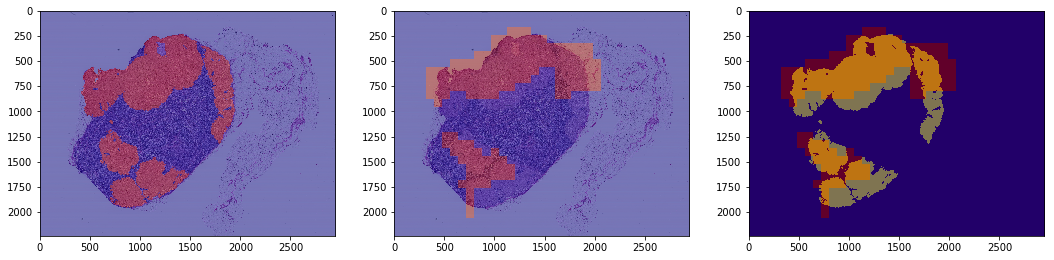

AUC:0.7817333331065


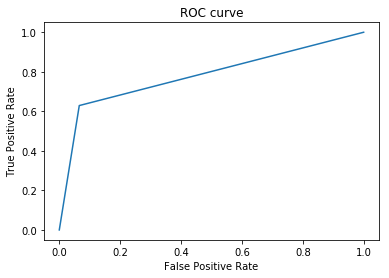

Threshold:  255
Sensitivity:0.6291207268022936
Specificity:0.9343459394107063
--------Confusion Matrix------
[[5201032  365463]
 [ 381288  646777]]
Recall:0.6291207268022936
Precision:0.6389561764008536
F1 Score:0.6340003087773641
Read WSI from ./slides/tumor_016.tif with width: 97792, height: 221184
13824 6112
6912 3056
500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 

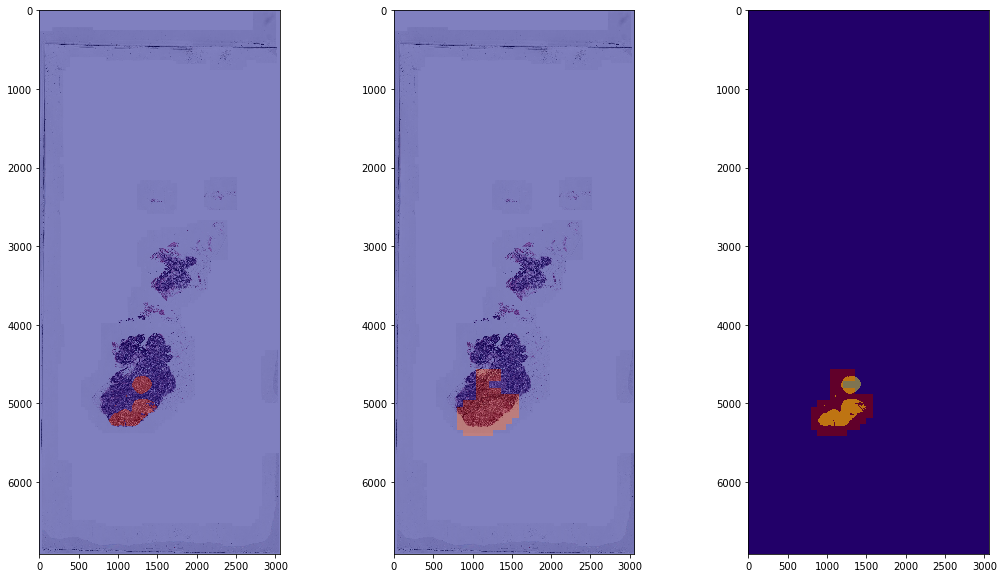

AUC:0.9219746867968608


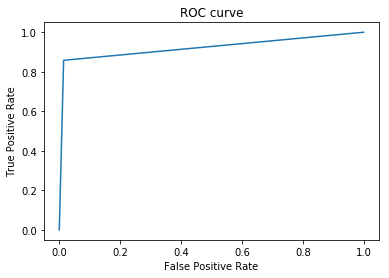

Threshold:  255
Sensitivity:0.8581611787413763
Specificity:0.9857881948523451
--------Confusion Matrix------
[[20668125   297966]
 [   22266   134715]]
Recall:0.8581611787413763
Precision:0.31134946993281426
F1 Score:0.45692277949062343
Read WSI from ./slides/tumor_078.tif with width: 94208, height: 111104
6944 5888
3472 2944
500, 1000, 1500, 2000, 2500, 

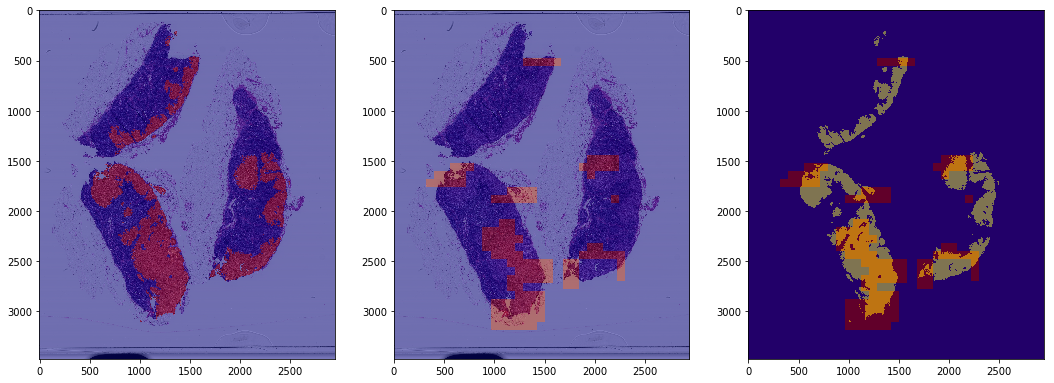

AUC:0.6667183529679418


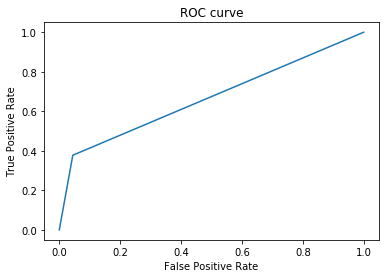

Threshold:  255
Sensitivity:0.3778236641511185
Specificity:0.9556130417847651
--------Confusion Matrix------
[[8861717  411615]
 [ 589970  358266]]
Recall:0.3778236641511185
Precision:0.46535243758450984
F1 Score:0.4170449393143773


In [107]:
# Generate heat maps for test slides. 

SLIDES = ['110','016','078']

for slide_num in SLIDES:
  slide_path = './slides/tumor_'+slide_num+'.tif'
  tumor_mask_path = './slides/tumor_'+slide_num+'_mask.tif'

  
  preds, patch_coord = get_pred(slide_path, lev2, lev1, window_size, center_size, stride)
  conf_mat, recall, precision, F1 = evaluate_pred(slide_path, tumor_mask_path, preds, patch_coord, lev2)